<a href="https://colab.research.google.com/github/Jakelinecs/Tareas-Machine-Learning/blob/main/N18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

class ScratchSVMClassifier():

    def __init__(self, num_iter=1000, lr=0.01, kernel='linear', threshold=1e-5, verbose=False,
                 gamma=1.0, theta0=0.0, d=3):
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose

        self.gamma = gamma
        self.theta0 = theta0
        self.d = d

        self.lam = None

# P1/P6:
    def _kernel_function(self, X1, X2):

        if self.kernel == 'linear':
            return X1 @ X2.T

        elif self.kernel == 'poly':
            return (self.gamma * (X1 @ X2.T) + self.theta0)**self.d

        else:
            raise ValueError("Unsupported kernel type. Use 'linear' or 'poly'.")

  # P1:
    def _lagrange_gradient_update(self, X, y):

        m = X.shape[0]

        K = self._kernel_function(X, X)

        y_outer = y[:, np.newaxis] * y[np.newaxis, :]

        lam_y_K = self.lam * y_outer * K

        sum_term = np.sum(lam_y_K, axis=1)

        gradient = 1.0 - sum_term

        self.lam = self.lam + self.lr * gradient

        self.lam[self.lam < 0] = 0

    def fit(self, X, y, X_val=None, y_val=None):


        m = X.shape[0]

        if np.min(y) == 0:
            y[y == 0] = -1

        self.lam = np.zeros(m)

        for i in range(self.iter):
            self._lagrange_gradient_update(X, y)

            if self.verbose and (i % 100 == 0):
                pass

        sv_mask = self.lam > self.threshold

        self.n_support_vectors = np.sum(sv_mask)
        self.index_support_vectors = np.where(sv_mask)[0]
        self.X_sv = X[sv_mask]
        self.lam_sv = self.lam[sv_mask]
        self.y_sv = y[sv_mask]

        if self.verbose:
            print(f"学習完了。サポートベクターの数: {self.n_support_vectors}")

# P3:
    def predict(self, X):

        K_nx = self._kernel_function(self.X_sv, X)

        lam_y_sv = self.lam_sv * self.y_sv

        f_x = lam_y_sv @ K_nx

        y_pred = np.sign(f_x)

        y_pred[y_pred == -1] = 0

        return y_pred

In [3]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

X, y = make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.0, random_state=42)

y[y == 0] = -1

X_train, y_train = X, y

svm_scratch = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5, verbose=True)

svm_scratch.fit(X_train, y_train)

y_pred_scratch = svm_scratch.predict(X_train)

y_train_binary = y_train.copy()
y_train_binary[y_train_binary == -1] = 0

acc_scratch = accuracy_score(y_train_binary, y_pred_scratch)

print("\n--- スクラッチ実装による評価 ---")
print(f"サポートベクターの数: {svm_scratch.n_support_vectors}")
print(f"Accuracy (訓練データ): {acc_scratch:.4f}")

svm_sklearn = SVC(kernel='linear', C=1e10, random_state=42)
svm_sklearn.fit(X_train, y_train_binary)
y_pred_sklearn = svm_sklearn.predict(X_train)
acc_sklearn = accuracy_score(y_train_binary, y_pred_sklearn)

print("\n--- scikit-learn実装との比較 ---")
print(f"Accuracy (scikit-learn, 訓練データ): {acc_sklearn:.4f}")
print(f"scikit-learnのサポートベクター数: {len(svm_sklearn.support_)}")

学習完了。サポートベクターの数: 3

--- スクラッチ実装による評価 ---
サポートベクターの数: 3
Accuracy (訓練データ): 1.0000

--- scikit-learn実装との比較 ---
Accuracy (scikit-learn, 訓練データ): 1.0000
scikit-learnのサポートベクター数: 2



--- 決定領域の可視化 (問題5) ---


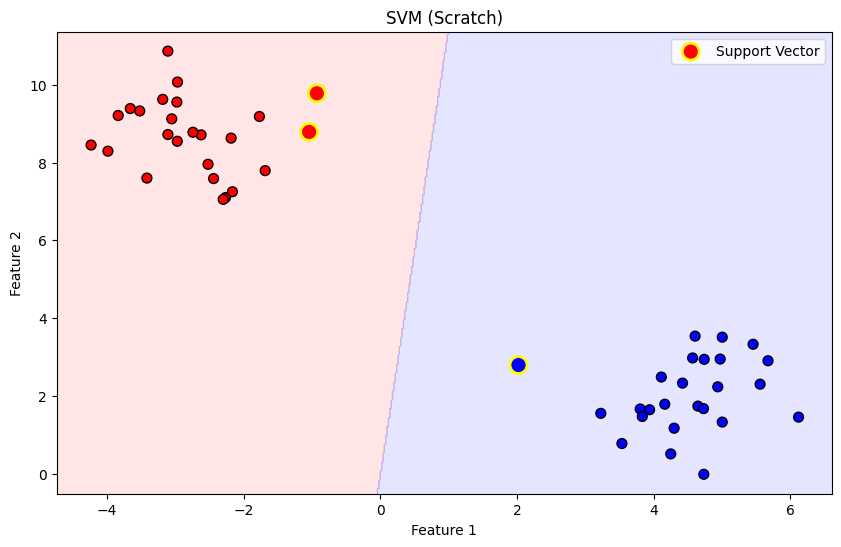

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary_svm(model, X, y, title):

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    cmap_boundary = ListedColormap(['#FFAAAA', '#AAAAFF'])
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_boundary)

    cmap_points = ListedColormap(['red', 'blue'])
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=cmap_points, s=50)

    X_sv = model.X_sv

    y_sv_binary = model.y_sv.copy()
    y_sv_binary[y_sv_binary == -1] = 0

    plt.scatter(X_sv[:, 0], X_sv[:, 1], c=y_sv_binary, edgecolors='yellow',
                cmap=cmap_points, s=150, linewidth=2, label='Support Vector')


    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

print("\n--- 決定領域の可視化 (問題5) ---")
# y_train は {-1, 1}だが、描画関数内で {0, 1}に変換して使用
plot_decision_boundary_svm(svm_scratch, X_train, y_train_binary,
                           "SVM (Scratch)")
#


--- INICIO DE VERIFICACIÓN DEL KERNEL POLINOMIAL ---
Entrenando SVM con Kernel Polinomial (Grado 3)...


/tmp/ipython-input-828076042.py:39: RuntimeWarning: overflow encountered in multiply
  lam_y_K = self.lam * y_outer * K
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipython-input-828076042.py:45: RuntimeWarning: invalid value encountered in add
  self.lam = self.lam + self.lr * gradient


学習完了。サポートベクターの数: 0

--- Evaluación del Kernel Polinomial ---
Nro. de Vectores de Soporte: 0
Accuracy (Entrenamiento): 0.5000


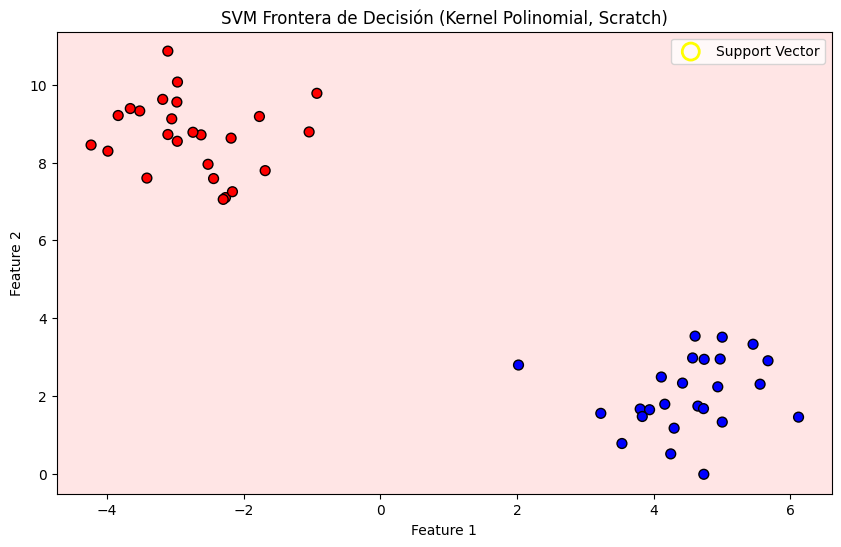

In [11]:

X, y = make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.0, random_state=42)

X_train, y_train = X, y.copy()
y_train[y_train == 0] = -1

y_train_binary = y.copy()


print("\n--- INICIO DE VERIFICACIÓN DEL KERNEL POLINOMIAL ---")

svm_poly_scratch = ScratchSVMClassifier(
    num_iter=8000,
    lr=0.0001,
    kernel='poly',
    gamma=1.0,
    theta0=1.0,
    d=3,
    threshold=1e-5,
    verbose=True
)

print("Entrenando SVM con Kernel Polinomial (Grado 3)...")
svm_poly_scratch.fit(X_train, y_train)

y_pred_poly_scratch = svm_poly_scratch.predict(X_train)
acc_poly_scratch = accuracy_score(y_train_binary, y_pred_poly_scratch)


print(f"\n--- Evaluación del Kernel Polinomial ---")
print(f"Nro. de Vectores de Soporte: {svm_poly_scratch.n_support_vectors}")
print(f"Accuracy (Entrenamiento): {acc_poly_scratch:.4f}")

plot_decision_boundary_svm(
    svm_poly_scratch,
    X_train,
    y_train_binary,
    "SVM Frontera de Decisión (Kernel Polinomial, Scratch)"
)